<a href="https://colab.research.google.com/github/WanjohiWanjohi/Term_deposits_uptake_predictor/blob/master/bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


#drive.mount('/content/drive')

In [135]:
#get the file 
#df =  pd.read_csv('bank-additional/bank-additional/bank-additional-full.csv' , sep=";" , engine='python')
df = pd.read_csv('/content/drive/My Drive/bank-additional-full.csv' , sep=";")
df.to_pickle("./bankcsv.pkl")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


 The duration skews the analysis as it is not known before a call is made and should therefore be dropped before we feed this data to our model 

In [136]:
df.drop('duration' , axis=1 , inplace=True)
df.info() , df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

(None,                age      campaign  ...     euribor3m   nr.employed
 count  41188.00000  41188.000000  ...  41188.000000  41188.000000
 mean      40.02406      2.567593  ...      3.621291   5167.035911
 std       10.42125      2.770014  ...      1.734447     72.251528
 min       17.00000      1.000000  ...      0.634000   4963.600000
 25%       32.00000      1.000000  ...      1.344000   5099.100000
 50%       38.00000      2.000000  ...      4.857000   5191.000000
 75%       47.00000      3.000000  ...      4.961000   5228.100000
 max       98.00000     56.000000  ...      5.045000   5228.100000
 
 [8 rows x 9 columns])

From the information , we can see we have no null entries in the dataframe 
Hence , we can go forward and process our data by:
1. Encoding Categorical Data
2. Scale
3. Class Balance in target variable
5. Aggregating and Transformation
6. Dimension reduction





#### Encode categorical data 
We use the get_dummies() function availed by pandas

0 indicates non existent while 1 indicates existent.


In [149]:
def convert_categorical(dataframe , columns):
   df = dataframe[columns]
   converted_df = pd.get_dummies(df)
   res = pd.concat([df, converted_df], axis=1)
   return res

def get_column_counts(df ):
  """
  Get count of unique items in the dataframe column
  """
  for c in df.columns:
    print(c)
    print(df[c].value_counts())

def scale_columns(df , column):
  """"
  Scale columns using MinMax scaler
  """
  col = df[column]
  scaler = MinMaxScaler() 
  num2 = scaler.fit_transform(col)
  num2 = pd.DataFrame(num2, columns = col.columns)
  return num2

def upsample(df , majority_col, minority_col):
  """"
  Perform upsampling by resampling while replacing
  """
  # we seperate the classes
  majority_class = df[majority_col]
  minority_class = df[minority_col]
  #Upsample minority class
  df_minority_upsampled = resample(minority_class, 
                                 replace=True,     # sample with replacement
                                 n_samples=36548,    # to match majority class
                                 random_state=123) # reproducible results
  # Combine majority class with upsampled minority class
  df_upsampled = pd.concat([majority_class, df_minority_upsampled])
  return df_upsampled

def convert_dates(df , column , format):
  """
  convert date and months to numerical format

  """
  months = []
  day_of_week = []
  #convert column items to strings
  
    #format months
  if format == "%b":
    for index, row in df[column].items():
      datetime_object = datetime.datetime.strptime(row , "%b")
      month_number = datetime_object.month
      months.append(month_number)
    return months
    ## format days
  elif format == "%a":
    for index, row in df[column].items():
      datetime_object = datetime.datetime.strptime(row , "%a")
      day_number = datetime_object.weekday()
      day_of_week.append(day_number)
    return day_of_week
  

In [115]:
categorical = ['job' , 'marital' , 'education' , 'contact' , 'housing' , 'default' , 'loan' , 'poutcome']
target = ['y' ]
binned = ['pdays']
dates = ['month' , 'day_of_week']

In [150]:
df = pd.read_pickle("./bankcsv.pkl")
converted_df = convert_categorical(df , categorical)
get_column_counts(converted_df)

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
contact
cellular     26144
telephone    15044
Name: contact, dtype: int64
housing
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
default
no         32588
unknown     8597
yes            3
Name: default, dtype: int64
loan
no         33950
yes         6248
unknown      990
Name: loan, 

In [148]:
month = convert_dates(df , dates[0]  , '%b')
day = convert_dates(df , dates[1] , '%a')


#### Scale
We scale the pdays , employee numbers and age columns column to have a restricted range

In [177]:
scaled = scale_columns(df , binned)
scaled_emp_no = scale_columns(df , ['nr.employed'])
scaled_age = scale_columns(df , ['age'])

#### Class Balancing
Imbalanced classes put “accuracy” out of business. This is a surprisingly common problem in machine learning (specifically in classification), occurring in datasets with a disproportionate ratio of observations in each class as is the case in our dataset with the target variable


In [57]:
#check existence of class imbalance
get_column_counts(df[target])

y
no     36548
yes     4640
Name: y, dtype: int64


With a population of 41,188 , the yes population makes up only 11% of the population
We handle this by upsampling the minority class(the yes)

1. First, we'll separate observations from each class into different DataFrames.
2. Next, we'll resample the minority class with replacement, setting the number of samples to match that of the majority class.
3. Finally, we'll combine the up-sampled minority class DataFrame with the original majority class DataFrame.



In [76]:
#   we start by encoding the content of the target column
target_df = convert_categorical(df , target)

#   use upsample function
upsampled = upsample(target_df ,'y_no' , 'y_yes' )

target_column = pd.DataFrame(upsampled)


#### Transform and Aggregate
*First , let us bring it all together into one dataframe*


In [178]:
#combine the encoded , scaled and datetime formatted columns
## drop the categorical columns
#   converted_df.drop(categorical , axis=1 , inplace=True)
converted_df

# bring in the campaign columns and the age column
converted_df['age'] = scaled_age
converted_df['campaign'] = df['campaign']
converted_df['previous'] = df['previous']
#bring in the derived month column
converted_df['month'] = month

#bring in the scaled employee numbers and number of days that pass before a customer is contacted
converted_df['pdays'] = scaled
converted_df['employee_no'] = scaled_emp_no



In [179]:
#calculate total number of contacts made with user
sum_column = converted_df['previous'] + converted_df['campaign']
converted_df['total_contacts'] = sum_column
converted_df

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,contact_cellular,contact_telephone,housing_no,housing_unknown,housing_yes,default_no,default_unknown,default_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success,campaign,month,pdays,employee_no,previous,total_contacts,age
0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,5,1.0,0.859735,0,1,0.481481
1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,1,5,1.0,0.859735,0,1,0.493827
2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,5,1.0,0.859735,0,1,0.246914
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,5,1.0,0.859735,0,1,0.283951
4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,5,1.0,0.859735,0,1,0.481481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1,11,1.0,0.000000,0,1,0.691358
41184,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,11,1.0,0.000000,0,1,0.358025
41185,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,2,11,1.0,0.000000,0,2,0.481481
41186,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,11,1.0,0.000000,0,1,0.333333


#### Reduce the dimensions
45 columns is a large number ; additionally some of them report the same result
Dimensionality reduction can be done in two different ways:

  - By only keeping the most relevant variables from the original dataset (this technique is called feature selection)
  - By finding a smaller set of new variables, each being a combination of the input variables, containing basically the same information as the input variables (this technique is called dimensionality reduction)


###### Low Variance filtering


In [166]:
variance = converted_df.var()
variance


job_admin.                       0.189013
job_blue-collar                  0.174202
job_entrepreneur                 0.034101
job_housemaid                    0.025074
job_management                   0.065953
job_retired                      0.040017
job_self-employed                0.033311
job_services                     0.087079
job_student                      0.020793
job_technician                   0.136914
job_unemployed                   0.024013
job_unknown                      0.007948
marital_divorced                 0.099439
marital_married                  0.238934
marital_single                   0.201982
marital_unknown                  0.001939
education_basic.4y               0.091111
education_basic.6y               0.052552
education_basic.9y               0.125229
education_high.school            0.177651
education_illiterate             0.000437
education_professional.course    0.111093
education_university.degree      0.208154
education_unknown                0

We can safely drop the day column since it varies never


In [180]:
# converted_df.drop('day' , axis=1 , inplace=True)
converted_df.astype('float64').dtypes


job_admin.                       float64
job_blue-collar                  float64
job_entrepreneur                 float64
job_housemaid                    float64
job_management                   float64
job_retired                      float64
job_self-employed                float64
job_services                     float64
job_student                      float64
job_technician                   float64
job_unemployed                   float64
job_unknown                      float64
marital_divorced                 float64
marital_married                  float64
marital_single                   float64
marital_unknown                  float64
education_basic.4y               float64
education_basic.6y               float64
education_basic.9y               float64
education_high.school            float64
education_illiterate             float64
education_professional.course    float64
education_university.degree      float64
education_unknown                float64
contact_cellular

##### Principal Compnent Analysis



In [182]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
feat_cols = converted_df.columns.tolist()
pca_result = pca.fit_transform(converted_df[feat_cols].values)

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

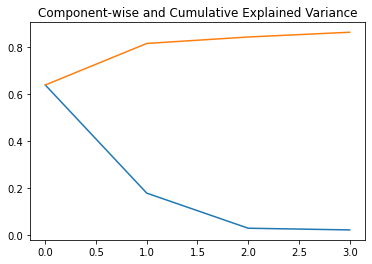

In [187]:
plt.plot(range(4), pca.explained_variance_ratio_)
plt.plot(range(4), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

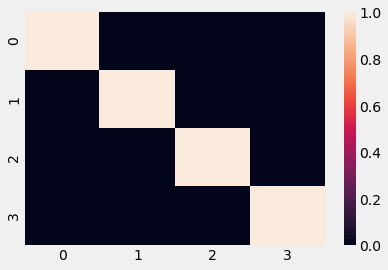

In [ ]:
diminished = pd.DataFrame(pca_result)
corr_mat = diminished.corr()

#### Encode categorical columns


From the above , we can see there are two main variables that impact the uptake of term deposits : previous and the number employed. As the number of contacts performed before this campaign for this client (*previous*) increases, the number of term deposits increases and as the number employed increases , the term deposits taken decrease

Additionally, as the number of days between contact campaigns increases, term deposits decrease

These are the potential columns that could be helpful in currently separating the target column
Let's now handle the outliers in order to not skew our analysis.

### Modeling
We use two main model approaches :
  - Logistic regression
  - XGBoost
  

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
X = df[feature_cols]   
y = df['y']
y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

From the value counts of y , we can see that there is a huge difference between the 1 and the 0 ; defined as a class imbalance . We can therefore go ahead to address this using 

In [ ]:
def logistic(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.1,random_state=1)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)
    return (prob,y_test)

probs , y_test  = logistic(X , y)


(array([[0.90884108, 0.09115892],
        [0.90788461, 0.09211539],
        [0.90884108, 0.09115892],
        ...,
        [0.90788461, 0.09211539],
        [0.90788461, 0.09211539],
        [0.90788461, 0.09211539]]), 35577    0
 13950    0
 29451    1
 32295    0
 27477    0
         ..
 38593    0
 33924    0
 23595    0
 22711    0
 23414    1
 Name: y, Length: 4119, dtype: int64)

In [ ]:
from sklearn.metrics import precision_recall_curve
disp = plot_precision_recall_curve(probs, y_test)
disp

NameError: ignored

## Scale the previous and number employed column

Get date data from date columns

In [ ]:
date_cols = []